# Analyzing Nouns



Project 4: Data Science for Linguistics

- Siddharth Vashishtha, Liz Lee, Nick Kasper


In [54]:
#Importing libraries
import keras
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import chi2, f_classif
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score,  cross_val_predict, KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC

#Remove warnings:
import warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)
#import h5py
#warnings.resetwarnings()

# Clasification:

## 1. Predicting Countability of a Noun

In [2]:
noun_df = pd.read_csv("noun_distributional_information.csv")
noun_df['countable_bool'] = noun_df['countable'].map({'Y': 1, 'N': 0})

In [3]:
noun_df.shape

(18264, 227)

#### Select only the numeric features

In [4]:
df_numeric = noun_df.select_dtypes(include=[np.number])
X = df_numeric.drop('countable_bool', axis=1)
feats = list(X.columns)
y = noun_df.countable_bool

print("Shape of numeric data: {}".format(X.shape))

Shape of numeric data: (18264, 209)


#### Raw distribution of Countable Nouns

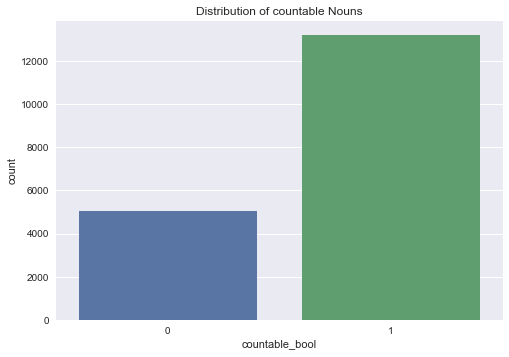

Distribution
1    0.723226
0    0.276774
Name: countable_bool, dtype: float64


In [5]:
sns.countplot(x='countable_bool', data=noun_df)
plt.title("Distribution of countable Nouns")
plt.show()
print("Distribution")
print(noun_df.countable_bool.value_counts(normalize=True))

### 1.1 Data Pre-processing:
#### Check for Missing Values

In [6]:
if df_numeric.isnull().values.any():
    print("Features have missing values")
else:
    print("None of the rows have missing values")

None of the rows have missing values


#### Number of features with constant values

In [7]:
const_feat = (np.std(X, axis=0) == 0)
print("Number of constant features: {}\n".format(sum(const_feat)))
const_idxs = list(np.where(const_feat)[0])
const_feat_names = [feats[idx] for idx in const_idxs]
print("Features with constant values:")
print(const_feat_names)

Number of constant features: 38

Features with constant values:
['Verb Negation Count', 'Verb Negation Percentage', 'An Percentage', 'Any Count', 'Any Percentage', 'Both Count', 'Both Percentage', 'Certain Count', 'Certain Percentage', 'Each Count', 'Each Percentage', 'Either Count', 'Either Percentage', 'Enough Percentage', 'Neither Count', 'Neither Percentage', 'Said Count', 'Said Percentage', 'Several Percentage', 'Such Count', 'Such Percentage', 'Sufficient Count', 'Sufficient Percentage', 'This Percentage', 'Various Count', 'Various Percentage', 'We Count', 'We Percentage', 'Whatever Count', 'Whatever Percentage', 'Whatsoever Count', 'Whatsoever Percentage', 'What Percentage', 'Whichever Count', 'Whichever Percentage', 'Which Count', 'Which Percentage', 'You Percentage']


#### Remove features with constant values

In [8]:
X = X.drop(const_feat_names, axis=1)

print("Updated number of features: {}".format(X.shape))

Updated number of features: (18264, 171)


### 1.2 Classification Using Support Vector Machines:

#### SVM-Anova: SVM with univariate feature selection¶

#### Create a feature-selection transform and an instance of SVM that we combine together to have an full-blown estimator

In [9]:
transform = feature_selection.SelectPercentile(feature_selection.f_classif)

We create a pipeline which takes the following actions:
- Normalizes the features
- Removes variables with zero variance
- Anova transformation : Pick variables based on best Anova F-value 
- Predict countability using SVM with rbf kernels!

In [10]:
clf = Pipeline([('scaler', StandardScaler()), ('var_thresh', VarianceThreshold()), 
                ('anova', transform), ('svc', svm.SVC(C=1.0, kernel='rbf'))])

In [11]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 10, 20, 30, 40, 60, 80, 100)
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, cv=5, n_jobs=1)
    print("Mean Accuracy at {} percentile of features selection: {}".format(percentile, this_scores.mean()))
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

Mean Accuracy at 1 percentile of features selection: 0.8229848443371575
Mean Accuracy at 10 percentile of features selection: 0.8504160184025553
Mean Accuracy at 20 percentile of features selection: 0.8551796614824527
Mean Accuracy at 30 percentile of features selection: 0.8601074182002879
Mean Accuracy at 40 percentile of features selection: 0.8612570681901385
Mean Accuracy at 60 percentile of features selection: 0.8609831856605428
Mean Accuracy at 80 percentile of features selection: 0.8603262363842049
Mean Accuracy at 100 percentile of features selection: 0.8592860104779669


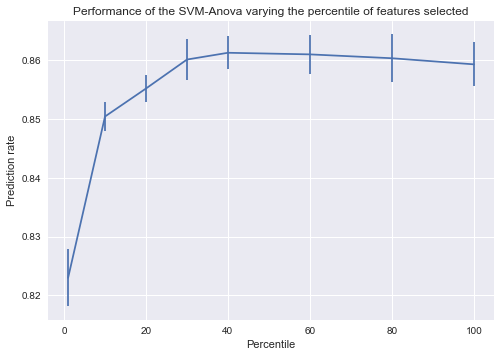

In [12]:
#Plot the graph of accuracies:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.axis('tight')
plt.show()

#### Plot with F1 score

In [13]:
score_means = list()
score_stds = list()
percentiles = (1, 10, 20, 30, 40, 60, 80, 100)
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, n_jobs=1, cv=5, scoring='f1_macro')
    print("Mean F1 score at {} percentile of features selection: {}".format(percentile, this_scores.mean()))
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


Mean F1 score at 1 percentile of features selection: 0.7783816196352795
Mean F1 score at 10 percentile of features selection: 0.8149918095167333
Mean F1 score at 20 percentile of features selection: 0.8218697970427025
Mean F1 score at 30 percentile of features selection: 0.8273787033712813
Mean F1 score at 40 percentile of features selection: 0.8285421652514943
Mean F1 score at 60 percentile of features selection: 0.82760307679721
Mean F1 score at 80 percentile of features selection: 0.8267281059998342
Mean F1 score at 100 percentile of features selection: 0.8251797403424526


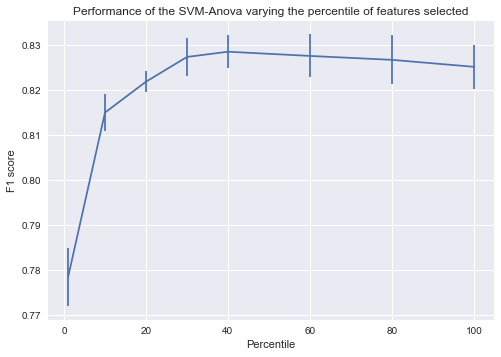

In [14]:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('F1 score')
plt.axis('tight')
plt.show()

Even though the actual distrubtion was 70-30. We see that our model is robust as it does similar on both F1 score and raw accuracy. It is seen that highest metric is achieved with 40 percentile of features. That implies that reducing the number of features does help in predicting the countability.

#### The Top Features

In [15]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)

# Create new dataframe with only desired columns, or overwrite existing
X_new = X[X.columns[idxs_selected]]

print(X_new.columns)

Index(['NN Percentage', 'NNS Percentage', 'Plural Noun Percentage',
       'Singular Noun Percentage', 'Bare Plural Noun Percentage',
       'Bare Singular Noun Percentage', 'Determiner Percentage',
       'Denumerator Percentage', 'A N Percentage',
       'Sing Subj Plu V Percentage'],
      dtype='object')


The best two features that seem to predict Countability of Nouns are:
    - Bare Singular Noun Percentage
    - Plural Noun Percentage

Let's look at the boxplots of some of the top 10 features to see if this result gives us some intuition about the result

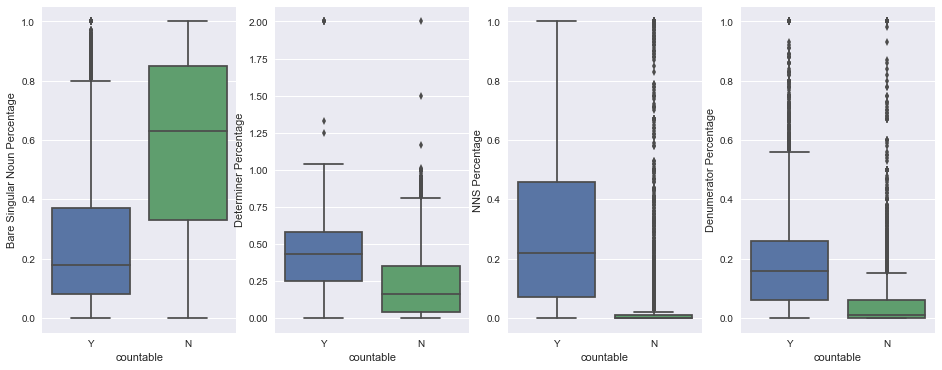

In [16]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16, 6), squeeze=False)
sns.boxplot(x="countable", y='Bare Singular Noun Percentage', data=noun_df, ax=axs[0,0])
sns.boxplot(x="countable", y='Determiner Percentage', data=noun_df, ax=axs[0,1])
sns.boxplot(x="countable", y='NNS Percentage', data=noun_df, ax=axs[0,2])
sns.boxplot(x="countable", y='Denumerator Percentage', data=noun_df, ax=axs[0,3])
plt.show()

Violin plots for the same variables:

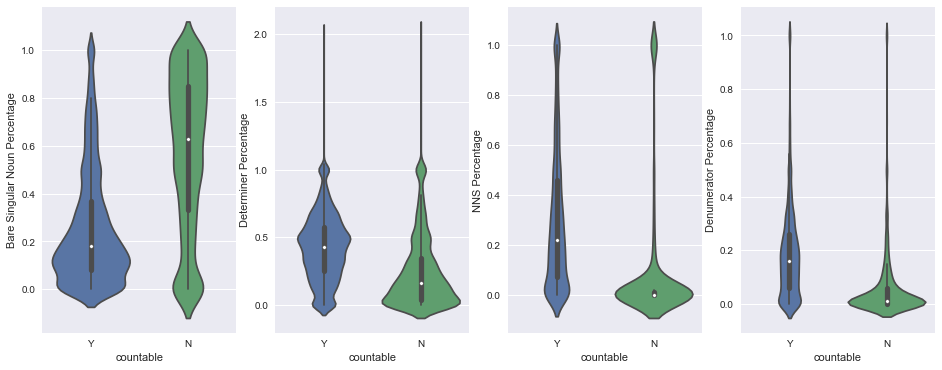

In [74]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16, 6), squeeze=False)
sns.violinplot(x="countable", y='Bare Singular Noun Percentage', data=noun_df, ax=axs[0,0])
sns.violinplot(x="countable", y='Determiner Percentage', data=noun_df, ax=axs[0,1])
sns.violinplot(x="countable", y='NNS Percentage', data=noun_df, ax=axs[0,2])
sns.violinplot(x="countable", y='Denumerator Percentage', data=noun_df, ax=axs[0,3])
plt.show()

## 2. Predicting Most likely Adjective Type for a Noun

In [56]:
adj_types = ['Adjtype: Behavior Avg', 'Adjtype: Body Avg', 'Adjtype: Feeling Avg', 'Adjtype: Mind Avg',
            'Adjtype: Miscellaneous Avg', 'Adjtype: Motion Avg', 'Adjtype: Perception Avg',
            'Adjtype: Quantity Avg','Adjtype: Social Avg','Adjtype: Spatial Avg','Adjtype: Substance Avg',
            'Adjtype: Temporal Avg','Adjtype: Weather Avg']



In [78]:
noun_df['Adj_Max'] = noun_df[adj_types].idxmax(axis=1)

#A sample of what this looks like
noun_df[['Noun', 'Adj_Max']].sample(10)

,Noun,Adj_Max
16941,troops,Adjtype: Quantity Avg
14001,scrooge,Adjtype: Behavior Avg
335,bait,Adjtype: Substance Avg
2135,colony,Adjtype: Quantity Avg
1786,churn,Adjtype: Perception Avg
3230,deadline,Adjtype: Temporal Avg
14259,sewer,Adjtype: Substance Avg
17703,warp,Adjtype: Substance Avg
5443,foil,Adjtype: Substance Avg
18157,wrong,Adjtype: Quantity Avg


#### Encoding Categories as Numeric data type

In [58]:
noun_df['Adj_Max_cat']= noun_df['Adj_Max'].astype('category')
noun_df['Adj_Max_codes'] = noun_df['Adj_Max_cat'].cat.codes

#Encoding of different classes:
encoding_dict = dict(enumerate(noun_df['Adj_Max_cat'].cat.categories))
for key, value in encoding_dict.items():
    print("{} : {}".format(key, value))

0 : Adjtype: Behavior Avg
1 : Adjtype: Body Avg
2 : Adjtype: Feeling Avg
3 : Adjtype: Mind Avg
4 : Adjtype: Miscellaneous Avg
5 : Adjtype: Motion Avg
6 : Adjtype: Perception Avg
7 : Adjtype: Quantity Avg
8 : Adjtype: Social Avg
9 : Adjtype: Spatial Avg
10 : Adjtype: Substance Avg
11 : Adjtype: Temporal Avg
12 : Adjtype: Weather Avg


#### X and y for this classification problem

In [59]:
X_adj = df_numeric.drop(const_feat_names + adj_types, axis=1) 
y_adj = noun_df.Adj_Max_codes
print(X_adj.shape)
print(y_adj.shape)

(18264, 159)
(18264,)


In [67]:
# Select top 40 percentile features:
selector = SelectKBest(f_classif, k=80)
selector.fit(X_adj, y_adj)

# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)

# Create new dataframe with only desired columns, or overwrite existing
X_adj_new = X_adj[X_adj.columns[idxs_selected]]

print(X_adj_new.shape)

(18264, 80)


#### Split train and test data

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_adj_new, y_adj, test_size=0.1, random_state=26)

print("Train data shape: {}".format(X_train.shape))
print("Test data shape: {}".format(X_test.shape))

Train data shape: (16437, 80)
Test data shape: (1827, 80)


#### Check cross-validation F1-scores for different percentile feature selection

In [70]:
#Set tuned parameters which would checked from cross-validation:
tuned_parameters = [{'kernel': ['rbf'],'C': [1, 10, 100]}]

scores = ['precision', 'recall']

In [71]:
#Classification report format taken from :
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'kernel': 'rbf'}

Grid scores on development set:

0.151 (+/-0.082) for {'C': 1, 'kernel': 'rbf'}
0.152 (+/-0.037) for {'C': 10, 'kernel': 'rbf'}
0.153 (+/-0.023) for {'C': 100, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.83      0.76      0.79       325
          1       0.22      0.07      0.11        29
          2       0.17      0.08      0.11       146
          3       0.00      0.00      0.00         7
          4       0.11      0.02      0.04       129
          5       0.00      0.00      0.00         3
          6       0.32      0.07      0.12       141
          7       0.12      0.03      0.05       224
          8       0.26      0.07      0.11       149
          9       0.11      0.03      

#### It turns out that finding this problem is quite hard based on the given features as the F1 scores are pretty low

#### What about accuracy? Let's find out

In [75]:
transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('scaler', StandardScaler()), ('var_thresh', VarianceThreshold()), 
                ('anova', transform), ('svc', svm.SVC(C=10.0, kernel='rbf'))])
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 10, 20, 30, 40, 60, 80, 100)
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X_adj, y_adj, cv=5, n_jobs=1)
    print("Mean Accuracy at {} percentile of features selection: {}".format(percentile, this_scores.mean()))
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

Mean Accuracy at 1 percentile of features selection: 0.30524734338849213
Mean Accuracy at 10 percentile of features selection: 0.3476209869111889
Mean Accuracy at 20 percentile of features selection: 0.3727027953058177
Mean Accuracy at 30 percentile of features selection: 0.3810211443526329
Mean Accuracy at 40 percentile of features selection: 0.3830481375618446
Mean Accuracy at 60 percentile of features selection: 0.3849626210673033
Mean Accuracy at 80 percentile of features selection: 0.3849107809897416
Mean Accuracy at 100 percentile of features selection: 0.3877576386962532


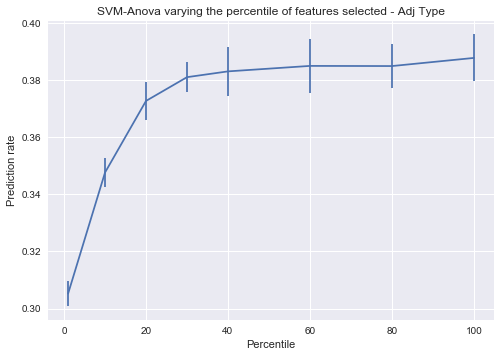

In [77]:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('SVM-Anova varying the percentile of features selected - Adj Type')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.axis('tight')
plt.show()

The best accuracy is also quite low i.e. 38%. This suggests that the problem is indeed hard and maybe better features are needed to solve this type of prediction.